In [ ]:
import pandas as pd
import os
from google.colab import drive, files
import numpy as np
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm.keras import TqdmCallback
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense

# Checking if a GPU is available and set the device accordingly
device = tf.device('/device:GPU:0' if tf.test.is_gpu_available() else '/device:CPU:0')

device

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
# Mounting Google Drive
drive.mount('/content/drive')

folder_path = '/content/drive/My Drive/Colab Notebooks/intern/'

Mounted at /content/drive


In [ ]:
# Function to load and preprocess the data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)
    # Scaling and EMA
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df.values)
    df_ema = apply_ema(pd.DataFrame(scaled_data, columns=df.columns))

    lagged_df = create_lagged_features(df_ema, n_lags=5)

    X = lagged_df.dropna().drop(columns=['t1', 't2'])  
    y = lagged_df[['t1', 't2']]  

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], 1, X.shape[1])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    return X_train, X_test, y_train, y_test

# Function to create EMA
def apply_ema(data, span=10):
    data['t1_ema'] = data['t1'].ewm(span=span, adjust=False).mean()
    data['t2_ema'] = data['t2'].ewm(span=span, adjust=False).mean()
    return data

# Function to create lagged features
def create_lagged_features(data, n_lags=5):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data = pd.concat([lagged_data, data[['t1', 't2']].shift(lag).add_suffix(f'_lag{lag}')], axis=1)
    lagged_data = lagged_data.dropna()  
    return lagged_data

# Initializing model building with Simple RNN
def build_model(X_train):
    model = Sequential([
        SimpleRNN(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  
        Dropout(0.5),
        SimpleRNN(64, return_sequences=False), 
        Dropout(0.2),
        Dense(2)  
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

In [ ]:
file_directory = '/content/drive/My Drive/Colab Notebooks/intern/'
files = [f for f in os.listdir(file_directory) if f.endswith('.csv')]

predictions = []
true_values = []

initial_file_path = os.path.join(file_directory, files[0])
X_train, X_test, y_train, y_test = preprocess_data(initial_file_path)

initial_model = build_model(X_train)
initial_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                  verbose=0,  
    callbacks=[TqdmCallback(verbose=1)] ) # Add tqdm callback)

# Saving the trained model
initial_model.save('pretrained_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [ ]:
pretrained_model_path = 'pretrained_model.h5'
fine_tuned_model = load_model(pretrained_model_path)
fine_tuned_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
batch_size = 20
predictions = []
true_values = []

for i in range(0, len(files), batch_size):
    batch_files = files[i:i + batch_size]
    print(f"Fine-tuning on batch {i // batch_size + 1}")

    for file in tqdm(batch_files, desc=f"Processing batch {i // batch_size + 1}"):
        file_path = os.path.join(file_directory, file)
        X_train, X_test, y_train, y_test = preprocess_data(file_path)

        fine_tuned_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

        y_pred = fine_tuned_model.predict(X_test)
        predictions.append(y_pred)
        true_values.append(y_test)

        # Optionally, plot training history for each file (if needed)

Fine-tuning on batch 1


Processing batch 1:   0%|          | 0/20 [00:00<?, ?it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Processing batch 1:   5%|▌         | 1/20 [00:27<08:48, 27.79s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  10%|█         | 2/20 [00:52<07:46, 25.90s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  15%|█▌        | 3/20 [01:19<07:32, 26.61s/it]

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Processing batch 1:  20%|██        | 4/20 [01:26<05:02, 18.89s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  25%|██▌       | 5/20 [01:54<05:28, 21.93s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 1:  30%|███       | 6/20 [02:16<05:08, 22.01s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 1:  35%|███▌      | 7/20 [02:41<05:00, 23.14s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  40%|████      | 8/20 [03:09<04:53, 24.44s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 1:  45%|████▌     | 9/20 [03:36<04:38, 25.29s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  50%|█████     | 10/20 [04:03<04:19, 25.97s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 1:  55%|█████▌    | 11/20 [04:25<03:43, 24.81s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  60%|██████    | 12/20 [04:57<03:35, 26.99s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  65%|██████▌   | 13/20 [05:23<03:05, 26.56s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 1:  70%|███████   | 14/20 [05:48<02:36, 26.07s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  75%|███████▌  | 15/20 [06:16<02:13, 26.77s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 1:  80%|████████  | 16/20 [06:43<01:46, 26.65s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  85%|████████▌ | 17/20 [07:07<01:18, 26.11s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  90%|█████████ | 18/20 [07:36<00:53, 26.83s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1:  95%|█████████▌| 19/20 [08:04<00:27, 27.27s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 1: 100%|██████████| 20/20 [08:32<00:00, 25.64s/it]


Fine-tuning on batch 2


Processing batch 2:   0%|          | 0/20 [00:00<?, ?it/s]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:   5%|▌         | 1/20 [00:25<08:12, 25.91s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  10%|█         | 2/20 [00:51<07:47, 25.98s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 2:  15%|█▌        | 3/20 [01:15<07:00, 24.74s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  20%|██        | 4/20 [01:42<06:51, 25.69s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  25%|██▌       | 5/20 [02:05<06:13, 24.93s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  30%|███       | 6/20 [02:33<06:00, 25.78s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  35%|███▌      | 7/20 [02:59<05:37, 25.94s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  40%|████      | 8/20 [03:28<05:21, 26.76s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  45%|████▌     | 9/20 [03:55<04:56, 26.93s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 2:  50%|█████     | 10/20 [04:24<04:36, 27.67s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  55%|█████▌    | 11/20 [04:48<03:58, 26.51s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  60%|██████    | 12/20 [05:12<03:26, 25.83s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 2:  65%|██████▌   | 13/20 [05:39<03:02, 26.03s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 2:  70%|███████   | 14/20 [06:05<02:36, 26.11s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  75%|███████▌  | 15/20 [06:28<02:05, 25.06s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 2:  80%|████████  | 16/20 [06:54<01:42, 25.52s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 2:  85%|████████▌ | 17/20 [07:18<01:14, 24.85s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 2:  90%|█████████ | 18/20 [07:41<00:48, 24.36s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 2:  95%|█████████▌| 19/20 [08:04<00:24, 24.08s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Processing batch 2: 100%|██████████| 20/20 [08:26<00:00, 25.33s/it]


Fine-tuning on batch 3


Processing batch 3:   0%|          | 0/5 [00:00<?, ?it/s]

90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3:  20%|██        | 1/5 [00:15<01:03, 15.81s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3:  40%|████      | 2/5 [00:38<01:00, 20.08s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3:  60%|██████    | 3/5 [01:05<00:46, 23.17s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Processing batch 3:  80%|████████  | 4/5 [01:28<00:23, 23.02s/it]

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Processing batch 3: 100%|██████████| 5/5 [01:52<00:00, 22.46s/it]


In [ ]:
fine_tuned_model.save('RNN_model.h5')

In [ ]:
from sklearn.metrics import r2_score

# Step 8: Evaluate the model on test data (modified)
test_loss, test_mae = fine_tuned_model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Calculate R-squared
y_pred = fine_tuned_model.predict(X_test)  # Get predictions
r2_t1 = r2_score(y_test[:, 0], y_pred[:, 0])  # R² for t1
r2_t2 = r2_score(y_test[:, 1], y_pred[:, 1])  # R² for t2

print(f"R-squared for t1: {r2_t1}")
print(f"R-squared for t2: {r2_t2}")

140/140 - 0s - 2ms/step - loss: 0.0029 - mae: 0.0382
Test Loss: 0.0028631375171244144, Test MAE: 0.038167499005794525
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R-squared for t1: 0.7576168976673441
R-squared for t2: 0.7524729657092337


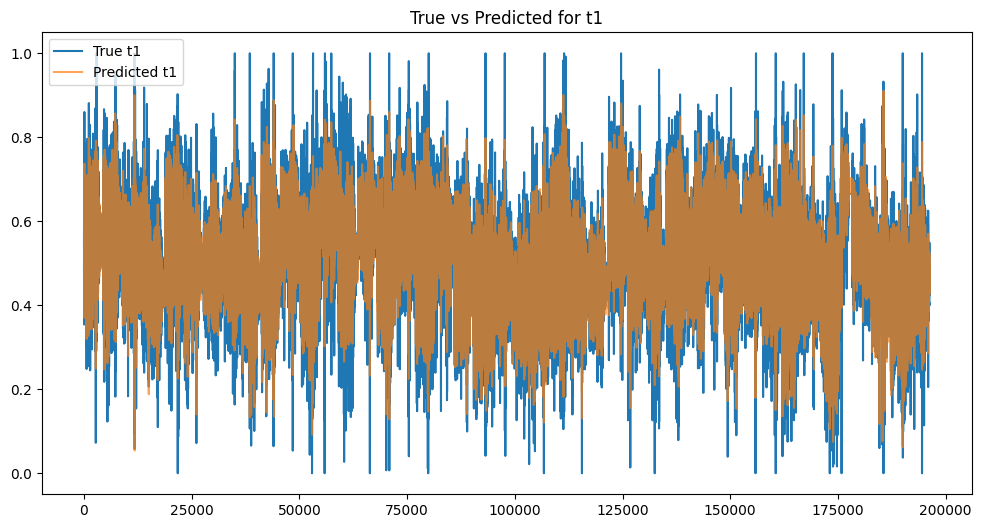

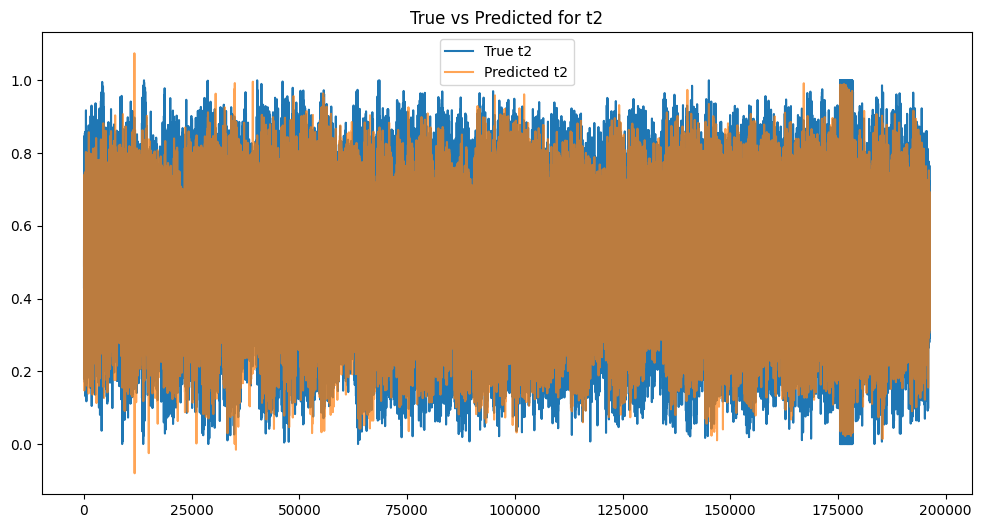

In [ ]:
predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

# Plotting true vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(true_values[:, 0], label='True t1')
plt.plot(predictions[:, 0], label='Predicted t1', alpha=0.7)
plt.title('True vs Predicted for t1')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(true_values[:, 1], label='True t2')
plt.plot(predictions[:, 1], label='Predicted t2', alpha=0.7)
plt.title('True vs Predicted for t2')
plt.legend()
plt.show()


In [ ]:
# Function to load and preprocess the data
def preprocess_data(file_path):
    df = pd.read_csv(file_path)

    df_ema = apply_ema(df)

    lagged_df = create_lagged_features(df_ema, n_lags=5)

    X = lagged_df.dropna().drop(columns=['t1', 't2'])  
    y = lagged_df[['t1', 't2']]  

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], 1, X.shape[1])

    return X, y



# Function to create EMA
def apply_ema(data, span=10):
    data['t1_ema'] = data['t1'].ewm(span=span, adjust=False).mean()
    data['t2_ema'] = data['t2'].ewm(span=span, adjust=False).mean()
    return data

# Function to create lagged features
def create_lagged_features(data, n_lags=5):
    lagged_data = data.copy()
    for lag in range(1, n_lags + 1):
        lagged_data = pd.concat([lagged_data, data[['t1', 't2']].shift(lag).add_suffix(f'_lag{lag}')], axis=1)
    lagged_data = lagged_data.dropna()  
    return lagged_data


# Load the data and preprocess
file_path = '/content/intern_v1_0703.csv' 
X, y = preprocess_data(file_path)


In [ ]:
# Function to forecast for different window sizes 
def forecast(model, X, windows=[60], batch_size=32):
    forecasts = {}
    for N in windows:
        forecasted_values = []

        for i in tqdm(range(0, len(X), batch_size), desc=f"Predicting for window size {N}"):
            batch_input = X[i:i+batch_size, :, :]
            batch_predictions = model.predict(batch_input)
            forecasted_values.append(batch_predictions)

        forecasted_values = np.vstack(forecasted_values)
        forecasts[N] = forecasted_values

    return forecasts

forecasted_values = forecast(load_model("/content/RNN_model.h5"), X)


Predicting for window size 60:   0%|          | 0/700 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step


Predicting for window size 60:   0%|          | 1/700 [00:00<10:01,  1.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:   0%|          | 3/700 [00:01<03:18,  3.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Predicting for window size 60:   1%|          | 5/700 [00:01<03:26,  3.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:   1%|          | 6/700 [00:01<02:51,  4.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:   1%|          | 7/700 [00:01<02:23,  4.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:   1%|          | 8/700 [00:01<02:02,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:   1%|▏         | 10/700 [00:02<01:37,  7.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:   2%|▏         | 11/700 [00:02<01:33,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:   2%|▏         | 12/700 [00:02<01:29,  7.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:   2%|▏         | 13/700 [00:02<01:28,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:   2%|▏         | 14/700 [00:02<01:27,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:   2%|▏         | 15/700 [00:02<01:22,  8.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:   2%|▏         | 16/700 [00:02<01:20,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:   2%|▏         | 17/700 [00:02<01:19,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:   3%|▎         | 18/700 [00:03<01:20,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:   3%|▎         | 19/700 [00:03<01:19,  8.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for window size 60:   3%|▎         | 20/700 [00:03<01:19,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:   3%|▎         | 21/700 [00:03<01:25,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:   3%|▎         | 22/700 [00:03<01:26,  7.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:   3%|▎         | 23/700 [00:03<01:29,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:   3%|▎         | 24/700 [00:03<01:26,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:   4%|▎         | 25/700 [00:03<01:23,  8.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:   4%|▎         | 26/700 [00:04<01:22,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:   4%|▍         | 27/700 [00:04<01:19,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:   4%|▍         | 28/700 [00:04<01:18,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:   4%|▍         | 29/700 [00:04<01:18,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:   4%|▍         | 30/700 [00:04<01:22,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:   4%|▍         | 31/700 [00:04<01:21,  8.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:   5%|▍         | 32/700 [00:04<01:24,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:   5%|▍         | 33/700 [00:04<01:23,  7.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:   5%|▍         | 34/700 [00:05<01:22,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:   5%|▌         | 35/700 [00:05<01:20,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:   5%|▌         | 37/700 [00:05<01:07,  9.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:   6%|▌         | 39/700 [00:05<01:05, 10.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:   6%|▌         | 41/700 [00:05<01:02, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:   6%|▌         | 43/700 [00:05<00:59, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:   6%|▋         | 45/700 [00:06<00:57, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:   7%|▋         | 47/700 [00:06<00:55, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:   7%|▋         | 49/700 [00:06<00:54, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:   7%|▋         | 51/700 [00:06<00:55, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:   8%|▊         | 53/700 [00:06<00:56, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:   8%|▊         | 55/700 [00:06<00:56, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:   8%|▊         | 57/700 [00:07<00:54, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:   8%|▊         | 59/700 [00:07<00:52, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:   9%|▊         | 61/700 [00:07<00:50, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:   9%|▉         | 63/700 [00:07<00:51, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:   9%|▉         | 65/700 [00:07<00:55, 11.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  10%|▉         | 67/700 [00:07<00:54, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  10%|▉         | 69/700 [00:08<00:54, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  10%|█         | 71/700 [00:08<00:52, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  10%|█         | 73/700 [00:08<00:51, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  11%|█         | 75/700 [00:08<00:54, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  11%|█         | 77/700 [00:08<00:54, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  11%|█▏        | 79/700 [00:08<00:53, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  12%|█▏        | 81/700 [00:09<00:52, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  12%|█▏        | 83/700 [00:09<00:52, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  12%|█▏        | 85/700 [00:09<00:53, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  12%|█▏        | 87/700 [00:09<00:54, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  13%|█▎        | 89/700 [00:09<00:51, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:  13%|█▎        | 91/700 [00:09<00:52, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  13%|█▎        | 93/700 [00:10<00:51, 11.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  14%|█▎        | 95/700 [00:10<00:49, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  14%|█▍        | 97/700 [00:10<00:51, 11.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  14%|█▍        | 99/700 [00:10<00:52, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  14%|█▍        | 101/700 [00:10<00:52, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  15%|█▍        | 103/700 [00:10<00:51, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  15%|█▌        | 105/700 [00:11<00:52, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  15%|█▌        | 107/700 [00:11<00:50, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  16%|█▌        | 109/700 [00:11<00:50, 11.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  16%|█▌        | 111/700 [00:11<00:51, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  16%|█▌        | 113/700 [00:11<00:51, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  16%|█▋        | 115/700 [00:12<00:51, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  17%|█▋        | 117/700 [00:12<00:49, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  17%|█▋        | 119/700 [00:12<00:48, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  17%|█▋        | 121/700 [00:12<00:50, 11.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  18%|█▊        | 123/700 [00:12<00:50, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  18%|█▊        | 125/700 [00:12<00:50, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  18%|█▊        | 127/700 [00:13<00:51, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  18%|█▊        | 129/700 [00:13<00:49, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  19%|█▊        | 131/700 [00:13<00:48, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  19%|█▉        | 133/700 [00:13<00:50, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  19%|█▉        | 135/700 [00:13<00:49, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  20%|█▉        | 137/700 [00:13<00:48, 11.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  20%|█▉        | 139/700 [00:14<00:48, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  20%|██        | 141/700 [00:14<00:48, 11.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  20%|██        | 143/700 [00:14<00:49, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  21%|██        | 145/700 [00:14<00:50, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  21%|██        | 147/700 [00:14<00:48, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  21%|██▏       | 149/700 [00:14<00:47, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  22%|██▏       | 151/700 [00:15<00:47, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Predicting for window size 60:  22%|██▏       | 153/700 [00:15<00:51, 10.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Predicting for window size 60:  22%|██▏       | 155/700 [00:15<00:58,  9.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  22%|██▏       | 156/700 [00:15<00:59,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for window size 60:  22%|██▏       | 157/700 [00:15<01:01,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  23%|██▎       | 158/700 [00:16<01:02,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  23%|██▎       | 159/700 [00:16<01:02,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  23%|██▎       | 160/700 [00:16<01:00,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting for window size 60:  23%|██▎       | 161/700 [00:16<01:04,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Predicting for window size 60:  23%|██▎       | 162/700 [00:16<01:13,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  23%|██▎       | 163/700 [00:16<01:13,  7.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  23%|██▎       | 164/700 [00:16<01:11,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:  24%|██▎       | 165/700 [00:16<01:09,  7.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  24%|██▎       | 166/700 [00:17<01:09,  7.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Predicting for window size 60:  24%|██▍       | 167/700 [00:17<01:09,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  24%|██▍       | 168/700 [00:17<01:09,  7.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for window size 60:  24%|██▍       | 169/700 [00:17<01:12,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  24%|██▍       | 170/700 [00:17<01:08,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  24%|██▍       | 171/700 [00:17<01:07,  7.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  25%|██▍       | 172/700 [00:17<01:07,  7.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  25%|██▍       | 173/700 [00:17<01:07,  7.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  25%|██▍       | 174/700 [00:18<01:08,  7.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for window size 60:  25%|██▌       | 175/700 [00:18<01:05,  7.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  25%|██▌       | 176/700 [00:18<01:05,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  25%|██▌       | 177/700 [00:18<01:07,  7.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Predicting for window size 60:  25%|██▌       | 178/700 [00:18<01:08,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  26%|██▌       | 179/700 [00:18<01:06,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  26%|██▌       | 180/700 [00:18<01:05,  7.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for window size 60:  26%|██▌       | 181/700 [00:18<01:04,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  26%|██▌       | 183/700 [00:19<00:55,  9.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  26%|██▋       | 185/700 [00:19<00:50, 10.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  27%|██▋       | 187/700 [00:19<00:50, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  27%|██▋       | 188/700 [00:19<00:51,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  27%|██▋       | 190/700 [00:19<00:48, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  27%|██▋       | 192/700 [00:19<00:45, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  28%|██▊       | 194/700 [00:20<00:44, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  28%|██▊       | 196/700 [00:20<00:43, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  28%|██▊       | 198/700 [00:20<00:45, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  29%|██▊       | 200/700 [00:20<00:45, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  29%|██▉       | 202/700 [00:20<00:44, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  29%|██▉       | 204/700 [00:21<00:42, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  29%|██▉       | 206/700 [00:21<00:42, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  30%|██▉       | 208/700 [00:21<00:41, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  30%|███       | 210/700 [00:21<00:44, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  30%|███       | 212/700 [00:21<00:44, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  31%|███       | 214/700 [00:21<00:42, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  31%|███       | 216/700 [00:22<00:42, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  31%|███       | 218/700 [00:22<00:40, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  31%|███▏      | 220/700 [00:22<00:41, 11.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  32%|███▏      | 222/700 [00:22<00:44, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  32%|███▏      | 224/700 [00:22<00:43, 10.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  32%|███▏      | 226/700 [00:22<00:41, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  33%|███▎      | 228/700 [00:23<00:39, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  33%|███▎      | 230/700 [00:23<00:38, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  33%|███▎      | 232/700 [00:23<00:39, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  33%|███▎      | 234/700 [00:23<00:41, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  34%|███▎      | 236/700 [00:23<00:41, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  34%|███▍      | 238/700 [00:23<00:40, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  34%|███▍      | 240/700 [00:24<00:40, 11.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  35%|███▍      | 242/700 [00:24<00:41, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  35%|███▍      | 244/700 [00:24<00:44, 10.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  35%|███▌      | 246/700 [00:24<00:45,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  35%|███▌      | 248/700 [00:24<00:44, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  36%|███▌      | 250/700 [00:25<00:44, 10.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  36%|███▌      | 252/700 [00:25<00:42, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  36%|███▋      | 254/700 [00:25<00:43, 10.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  37%|███▋      | 256/700 [00:25<00:41, 10.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  37%|███▋      | 258/700 [00:25<00:40, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  37%|███▋      | 260/700 [00:26<00:38, 11.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  37%|███▋      | 262/700 [00:26<00:38, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  38%|███▊      | 264/700 [00:26<00:37, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  38%|███▊      | 266/700 [00:26<00:39, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  38%|███▊      | 268/700 [00:26<00:39, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  39%|███▊      | 270/700 [00:26<00:38, 11.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  39%|███▉      | 272/700 [00:27<00:37, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  39%|███▉      | 274/700 [00:27<00:36, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  39%|███▉      | 276/700 [00:27<00:37, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  40%|███▉      | 278/700 [00:27<00:38, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  40%|████      | 280/700 [00:27<00:37, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  40%|████      | 282/700 [00:28<00:36, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  41%|████      | 284/700 [00:28<00:35, 11.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  41%|████      | 286/700 [00:28<00:34, 11.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  41%|████      | 288/700 [00:28<00:37, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  41%|████▏     | 290/700 [00:28<00:38, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  42%|████▏     | 292/700 [00:29<00:42,  9.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  42%|████▏     | 293/700 [00:29<00:45,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  42%|████▏     | 294/700 [00:29<00:47,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


Predicting for window size 60:  42%|████▏     | 295/700 [00:29<00:50,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for window size 60:  42%|████▏     | 296/700 [00:29<01:02,  6.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  42%|████▏     | 297/700 [00:29<01:10,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Predicting for window size 60:  43%|████▎     | 298/700 [00:30<01:15,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


Predicting for window size 60:  43%|████▎     | 299/700 [00:30<01:21,  4.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


Predicting for window size 60:  43%|████▎     | 300/700 [00:30<01:39,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


Predicting for window size 60:  43%|████▎     | 301/700 [00:31<01:40,  3.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


Predicting for window size 60:  43%|████▎     | 302/700 [00:31<01:37,  4.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Predicting for window size 60:  43%|████▎     | 303/700 [00:31<01:34,  4.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Predicting for window size 60:  43%|████▎     | 304/700 [00:31<01:33,  4.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Predicting for window size 60:  44%|████▎     | 305/700 [00:31<01:36,  4.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  44%|████▎     | 306/700 [00:32<01:23,  4.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  44%|████▍     | 307/700 [00:32<01:11,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  44%|████▍     | 308/700 [00:32<01:04,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  44%|████▍     | 309/700 [00:32<00:59,  6.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  44%|████▍     | 310/700 [00:32<00:58,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  44%|████▍     | 311/700 [00:32<00:56,  6.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  45%|████▍     | 312/700 [00:32<00:54,  7.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  45%|████▍     | 313/700 [00:33<00:54,  7.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  45%|████▍     | 314/700 [00:33<00:51,  7.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  45%|████▌     | 315/700 [00:33<00:49,  7.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  45%|████▌     | 316/700 [00:33<00:48,  7.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


Predicting for window size 60:  45%|████▌     | 317/700 [00:33<00:51,  7.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  45%|████▌     | 318/700 [00:33<00:52,  7.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  46%|████▌     | 320/700 [00:33<00:43,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  46%|████▌     | 322/700 [00:34<00:38,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  46%|████▋     | 324/700 [00:34<00:36, 10.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  47%|████▋     | 326/700 [00:34<00:34, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  47%|████▋     | 328/700 [00:34<00:34, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  47%|████▋     | 330/700 [00:34<00:34, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  47%|████▋     | 332/700 [00:34<00:33, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  48%|████▊     | 334/700 [00:35<00:32, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  48%|████▊     | 336/700 [00:35<00:32, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  48%|████▊     | 338/700 [00:35<00:31, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  49%|████▊     | 340/700 [00:35<00:32, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  49%|████▉     | 342/700 [00:35<00:32, 11.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  49%|████▉     | 344/700 [00:35<00:31, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  49%|████▉     | 346/700 [00:36<00:31, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  50%|████▉     | 348/700 [00:36<00:30, 11.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  50%|█████     | 350/700 [00:36<00:30, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  50%|█████     | 352/700 [00:36<00:31, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  51%|█████     | 354/700 [00:36<00:32, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  51%|█████     | 356/700 [00:37<00:31, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  51%|█████     | 358/700 [00:37<00:31, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  51%|█████▏    | 360/700 [00:37<00:30, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  52%|█████▏    | 362/700 [00:37<00:30, 11.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  52%|█████▏    | 364/700 [00:37<00:30, 11.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  52%|█████▏    | 366/700 [00:37<00:29, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  53%|█████▎    | 368/700 [00:38<00:30, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  53%|█████▎    | 370/700 [00:38<00:29, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  53%|█████▎    | 372/700 [00:38<00:29, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  53%|█████▎    | 374/700 [00:38<00:29, 10.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  54%|█████▎    | 376/700 [00:38<00:28, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  54%|█████▍    | 378/700 [00:38<00:28, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  54%|█████▍    | 380/700 [00:39<00:28, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  55%|█████▍    | 382/700 [00:39<00:27, 11.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  55%|█████▍    | 384/700 [00:39<00:28, 10.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  55%|█████▌    | 386/700 [00:39<00:28, 11.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  55%|█████▌    | 388/700 [00:39<00:27, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  56%|█████▌    | 390/700 [00:40<00:27, 11.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  56%|█████▌    | 392/700 [00:40<00:27, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  56%|█████▋    | 394/700 [00:40<00:27, 11.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  57%|█████▋    | 396/700 [00:40<00:27, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  57%|█████▋    | 398/700 [00:40<00:26, 11.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  57%|█████▋    | 400/700 [00:40<00:24, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  57%|█████▋    | 402/700 [00:41<00:25, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  58%|█████▊    | 404/700 [00:41<00:25, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  58%|█████▊    | 406/700 [00:41<00:25, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  58%|█████▊    | 408/700 [00:41<00:26, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  59%|█████▊    | 410/700 [00:41<00:25, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  59%|█████▉    | 412/700 [00:41<00:24, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  59%|█████▉    | 414/700 [00:42<00:24, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  59%|█████▉    | 416/700 [00:42<00:25, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  60%|█████▉    | 418/700 [00:42<00:25, 10.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  60%|██████    | 420/700 [00:42<00:25, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  60%|██████    | 422/700 [00:42<00:24, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  61%|██████    | 424/700 [00:43<00:23, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  61%|██████    | 426/700 [00:43<00:23, 11.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  61%|██████    | 428/700 [00:43<00:23, 11.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  61%|██████▏   | 430/700 [00:43<00:24, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  62%|██████▏   | 432/700 [00:43<00:27,  9.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  62%|██████▏   | 434/700 [00:44<00:28,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  62%|██████▏   | 435/700 [00:44<00:28,  9.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  62%|██████▏   | 436/700 [00:44<00:29,  9.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for window size 60:  62%|██████▏   | 437/700 [00:44<00:30,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  63%|██████▎   | 438/700 [00:44<00:32,  8.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  63%|██████▎   | 439/700 [00:44<00:32,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  63%|██████▎   | 440/700 [00:44<00:31,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  63%|██████▎   | 441/700 [00:44<00:30,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  63%|██████▎   | 442/700 [00:45<00:31,  8.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  63%|██████▎   | 443/700 [00:45<00:29,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  63%|██████▎   | 444/700 [00:45<00:28,  8.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


Predicting for window size 60:  64%|██████▎   | 445/700 [00:45<00:29,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting for window size 60:  64%|██████▎   | 446/700 [00:45<00:30,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  64%|██████▍   | 447/700 [00:45<00:32,  7.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  64%|██████▍   | 448/700 [00:45<00:32,  7.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  64%|██████▍   | 449/700 [00:45<00:32,  7.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  64%|██████▍   | 450/700 [00:46<00:30,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:  64%|██████▍   | 451/700 [00:46<00:30,  8.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  65%|██████▍   | 452/700 [00:46<00:30,  8.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:  65%|██████▍   | 453/700 [00:46<00:31,  7.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Predicting for window size 60:  65%|██████▍   | 454/700 [00:46<00:32,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  65%|██████▌   | 455/700 [00:46<00:31,  7.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  65%|██████▌   | 456/700 [00:46<00:31,  7.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  65%|██████▌   | 457/700 [00:46<00:29,  8.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  65%|██████▌   | 458/700 [00:47<00:28,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  66%|██████▌   | 459/700 [00:47<00:27,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  66%|██████▌   | 460/700 [00:47<00:27,  8.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for window size 60:  66%|██████▌   | 461/700 [00:47<00:29,  8.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


Predicting for window size 60:  66%|██████▌   | 462/700 [00:47<00:32,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  66%|██████▌   | 463/700 [00:47<00:33,  7.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  66%|██████▋   | 464/700 [00:47<00:32,  7.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  67%|██████▋   | 466/700 [00:48<00:26,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  67%|██████▋   | 468/700 [00:48<00:23,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  67%|██████▋   | 470/700 [00:48<00:21, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  67%|██████▋   | 472/700 [00:48<00:22, 10.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  68%|██████▊   | 474/700 [00:48<00:23,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  68%|██████▊   | 476/700 [00:48<00:22, 10.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  68%|██████▊   | 478/700 [00:49<00:20, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  69%|██████▊   | 480/700 [00:49<00:20, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  69%|██████▉   | 482/700 [00:49<00:20, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  69%|██████▉   | 484/700 [00:49<00:20, 10.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  69%|██████▉   | 486/700 [00:49<00:20, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  70%|██████▉   | 488/700 [00:50<00:19, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  70%|███████   | 490/700 [00:50<00:19, 10.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  70%|███████   | 492/700 [00:50<00:19, 10.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  71%|███████   | 494/700 [00:50<00:19, 10.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  71%|███████   | 496/700 [00:50<00:19, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  71%|███████   | 498/700 [00:51<00:18, 10.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  71%|███████▏  | 500/700 [00:51<00:18, 10.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  72%|███████▏  | 502/700 [00:51<00:17, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  72%|███████▏  | 504/700 [00:51<00:18, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  72%|███████▏  | 506/700 [00:51<00:18, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Predicting for window size 60:  73%|███████▎  | 508/700 [00:51<00:17, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  73%|███████▎  | 510/700 [00:52<00:16, 11.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  73%|███████▎  | 512/700 [00:52<00:16, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  73%|███████▎  | 514/700 [00:52<00:16, 11.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  74%|███████▎  | 516/700 [00:52<00:17, 10.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  74%|███████▍  | 518/700 [00:52<00:16, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  74%|███████▍  | 520/700 [00:53<00:16, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  75%|███████▍  | 522/700 [00:53<00:16, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  75%|███████▍  | 524/700 [00:53<00:15, 11.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  75%|███████▌  | 526/700 [00:53<00:16, 10.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  75%|███████▌  | 528/700 [00:53<00:16, 10.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  76%|███████▌  | 530/700 [00:53<00:15, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  76%|███████▌  | 532/700 [00:54<00:15, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  76%|███████▋  | 534/700 [00:54<00:14, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  77%|███████▋  | 536/700 [00:54<00:15, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  77%|███████▋  | 538/700 [00:54<00:15, 10.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  77%|███████▋  | 540/700 [00:54<00:15, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  77%|███████▋  | 542/700 [00:55<00:14, 10.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  78%|███████▊  | 544/700 [00:55<00:13, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  78%|███████▊  | 546/700 [00:55<00:13, 11.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  78%|███████▊  | 548/700 [00:55<00:14, 10.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  79%|███████▊  | 550/700 [00:55<00:13, 10.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  79%|███████▉  | 552/700 [00:55<00:13, 10.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  79%|███████▉  | 554/700 [00:56<00:13, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  79%|███████▉  | 556/700 [00:56<00:12, 11.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  80%|███████▉  | 558/700 [00:56<00:13, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  80%|████████  | 560/700 [00:56<00:13, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  80%|████████  | 562/700 [00:56<00:13, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  81%|████████  | 564/700 [00:57<00:12, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  81%|████████  | 566/700 [00:57<00:12, 10.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  81%|████████  | 568/700 [00:57<00:11, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  81%|████████▏ | 570/700 [00:57<00:12, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60:  82%|████████▏ | 572/700 [00:57<00:12, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Predicting for window size 60:  82%|████████▏ | 574/700 [00:58<00:13,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  82%|████████▏ | 575/700 [00:58<00:13,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  82%|████████▏ | 576/700 [00:58<00:13,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for window size 60:  82%|████████▏ | 577/700 [00:58<00:15,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  83%|████████▎ | 578/700 [00:58<00:14,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step


Predicting for window size 60:  83%|████████▎ | 579/700 [00:59<00:29,  4.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Predicting for window size 60:  83%|████████▎ | 580/700 [00:59<00:35,  3.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  83%|████████▎ | 581/700 [00:59<00:29,  4.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  83%|████████▎ | 582/700 [00:59<00:25,  4.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for window size 60:  83%|████████▎ | 583/700 [01:00<00:23,  5.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  83%|████████▎ | 584/700 [01:00<00:20,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  84%|████████▎ | 585/700 [01:00<00:18,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  84%|████████▎ | 586/700 [01:00<00:17,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


Predicting for window size 60:  84%|████████▍ | 587/700 [01:00<00:18,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  84%|████████▍ | 588/700 [01:00<00:16,  6.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  84%|████████▍ | 589/700 [01:00<00:15,  7.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting for window size 60:  84%|████████▍ | 590/700 [01:01<00:15,  7.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


Predicting for window size 60:  84%|████████▍ | 591/700 [01:01<00:15,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  85%|████████▍ | 592/700 [01:01<00:14,  7.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


Predicting for window size 60:  85%|████████▍ | 593/700 [01:01<00:15,  6.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Predicting for window size 60:  85%|████████▍ | 594/700 [01:01<00:16,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60:  85%|████████▌ | 595/700 [01:01<00:15,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Predicting for window size 60:  85%|████████▌ | 596/700 [01:01<00:15,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  85%|████████▌ | 597/700 [01:02<00:14,  6.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  86%|████████▌ | 599/700 [01:02<00:12,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  86%|████████▌ | 601/700 [01:02<00:10,  9.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  86%|████████▌ | 602/700 [01:02<00:11,  8.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  86%|████████▋ | 604/700 [01:02<00:09,  9.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  86%|████████▋ | 605/700 [01:02<00:09,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Predicting for window size 60:  87%|████████▋ | 607/700 [01:03<00:09,  9.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  87%|████████▋ | 608/700 [01:03<00:09,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  87%|████████▋ | 609/700 [01:03<00:09,  9.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  87%|████████▋ | 610/700 [01:03<00:09,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  87%|████████▋ | 611/700 [01:03<00:10,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  87%|████████▋ | 612/700 [01:03<00:10,  8.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  88%|████████▊ | 614/700 [01:03<00:09,  9.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  88%|████████▊ | 615/700 [01:03<00:08,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  88%|████████▊ | 616/700 [01:04<00:08,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  88%|████████▊ | 617/700 [01:04<00:08,  9.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


Predicting for window size 60:  88%|████████▊ | 618/700 [01:04<00:08,  9.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  88%|████████▊ | 619/700 [01:04<00:08,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Predicting for window size 60:  89%|████████▊ | 620/700 [01:04<00:08,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


Predicting for window size 60:  89%|████████▊ | 621/700 [01:04<00:08,  8.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  89%|████████▉ | 623/700 [01:04<00:07,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  89%|████████▉ | 624/700 [01:04<00:07,  9.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  89%|████████▉ | 626/700 [01:05<00:06, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  90%|████████▉ | 628/700 [01:05<00:06, 11.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  90%|█████████ | 630/700 [01:05<00:06, 10.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  90%|█████████ | 632/700 [01:05<00:06,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  91%|█████████ | 634/700 [01:05<00:06, 10.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  91%|█████████ | 636/700 [01:06<00:06, 10.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  91%|█████████ | 638/700 [01:06<00:05, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  91%|█████████▏| 640/700 [01:06<00:05, 11.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Predicting for window size 60:  92%|█████████▏| 642/700 [01:06<00:05, 10.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  92%|█████████▏| 644/700 [01:06<00:05, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  92%|█████████▏| 646/700 [01:06<00:04, 10.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  93%|█████████▎| 648/700 [01:07<00:04, 10.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  93%|█████████▎| 650/700 [01:07<00:04, 11.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  93%|█████████▎| 652/700 [01:07<00:04, 11.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  93%|█████████▎| 654/700 [01:07<00:04, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  94%|█████████▎| 656/700 [01:07<00:04, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  94%|█████████▍| 658/700 [01:08<00:04, 10.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Predicting for window size 60:  94%|█████████▍| 660/700 [01:08<00:03, 10.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  95%|█████████▍| 662/700 [01:08<00:03, 10.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  95%|█████████▍| 664/700 [01:08<00:03,  9.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  95%|█████████▌| 666/700 [01:08<00:03, 10.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  95%|█████████▌| 668/700 [01:09<00:03, 10.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  96%|█████████▌| 670/700 [01:09<00:03,  9.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Predicting for window size 60:  96%|█████████▌| 671/700 [01:09<00:03,  9.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  96%|█████████▌| 672/700 [01:09<00:02,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  96%|█████████▌| 673/700 [01:09<00:02,  9.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  96%|█████████▋| 675/700 [01:09<00:02,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Predicting for window size 60:  97%|█████████▋| 676/700 [01:09<00:02,  9.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  97%|█████████▋| 677/700 [01:10<00:02,  9.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  97%|█████████▋| 679/700 [01:10<00:02, 10.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


Predicting for window size 60:  97%|█████████▋| 681/700 [01:10<00:01, 10.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Predicting for window size 60:  98%|█████████▊| 683/700 [01:10<00:01,  9.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Predicting for window size 60:  98%|█████████▊| 685/700 [01:10<00:01, 10.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Predicting for window size 60:  98%|█████████▊| 687/700 [01:10<00:01, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  98%|█████████▊| 689/700 [01:11<00:01, 10.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60:  99%|█████████▊| 691/700 [01:11<00:00, 10.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  99%|█████████▉| 693/700 [01:11<00:00,  9.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Predicting for window size 60:  99%|█████████▉| 694/700 [01:11<00:00,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Predicting for window size 60:  99%|█████████▉| 695/700 [01:11<00:00,  9.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Predicting for window size 60:  99%|█████████▉| 696/700 [01:11<00:00,  9.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Predicting for window size 60: 100%|█████████▉| 697/700 [01:12<00:00,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


Predicting for window size 60: 100%|█████████▉| 698/700 [01:12<00:00,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


Predicting for window size 60: 100%|█████████▉| 699/700 [01:12<00:00,  8.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step


Predicting for window size 60: 100%|██████████| 700/700 [01:13<00:00,  9.57it/s]


In [ ]:
def plot_forecasts(forecasts, true_values):
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=np.arange(len(true_values)), y=true_values[:, 0], mode='lines', name='Actual t1'))
    fig.add_trace(go.Scatter(x=np.arange(len(true_values)), y=true_values[:, 1], mode='lines', name='Actual t2'))

    for window, forecasted in forecasts.items():
        forecasted_x = np.arange(len(true_values), len(true_values) + len(forecasted))

        fig.add_trace(go.Scatter(x=forecasted_x, y=forecasted[:, 0], mode='lines', name=f'Forecasted t1 (N={window})'))
        fig.add_trace(go.Scatter(x=forecasted_x, y=forecasted[:, 1], mode='lines', name=f'Forecasted t2 (N={window})'))

    fig.update_layout(title='True and Forecasted Values for t1 and t2',
                      xaxis_title='Time Steps',
                      yaxis_title='Values',
                      template='plotly_dark')

    fig.show()

plot_forecasts(forecasted_values, y)
